In [1]:
import librosa
import numpy as np
import scipy 
from scipy.signal.windows import hann
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Установка констант и определение необходимых функций

In [2]:
PATH = '../DSP/dsp_labs_book-main/resources/waves_yesno/'

SR = 22050

WINDOW_MS = 25
STEP_MS = 10
N_FFT = WINDOW_MS * SR // 1000 
HOP_LENGTH = STEP_MS * SR // 1000
N_MFCC = 13

In [3]:
def load_data(dir_):
    """Загрузка данных с диска"""
    
    X, targets = [], []
    bad_files = set(["0_1_0_1_0_0_0_0"])
    
    for file in glob(dir_ + "/*.wav"):
        name = os.path.basename(file)[:-4]
        if name in bad_files:
            continue
        y = [int(label) for label in name.split("_")]
        x, _ = librosa.load(file)
        X.append(x)
        targets.append(y)
    
    return X, targets


def VAD(x, sr, mode='same'):
    """Реализация VAD"""
    
    threshold = 90
    win_len = 10
    conv_mode = 'same'
    
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mfcc_conv = scipy.signal.convolve(mfcc[1, :], hann(win_len), mode=conv_mode) / win_len
    
    res = np.short(mfcc_conv - threshold > 0)
    
    if mode == 'same':
        res = np.repeat(res, HOP_LENGTH)
        n = len(x) - len(res)
        if n > 0:
            res = np.pad(res, n)[n:]
        else:
            res = res[:len(x)]
    
    return res


def make_dataset(x, y, VAD, sr):
    """Создание набора данных"""
    
    X, Y = [], []
    
    for i, (item, target) in enumerate(zip(x, y)):
        
        vad = VAD(item, sr, mode=None)
        mfcc = librosa.feature.mfcc(y=item, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
        
        indexes = []
        n = len(vad) - 1
        for j in range(n):
            if vad[j] != vad[j + 1]:
                indexes.append(j + 1)
        
        for k, j in enumerate(range(0, len(indexes), 2)):
            mfcc_mean = np.mean(mfcc[:, indexes[j]: indexes[j + 1]], axis=1)
            X.append(mfcc_mean)
            Y.append(target[k])
    
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


def vad_vis(index, x_train, vad_trained):
    """Визуализация работы VAD"""
    plt.figure(figsize=(10, 5))
    plt.plot(vad_trained[index])
    plt.plot(x_train[index])
    return


def learning_curve_vis(clf, x_train, y_train, scoring):
    """Визуализация кривых обучения"""
    plt.figure(figsize=(5, 3))
    train_sizes, train_scores, test_scores = learning_curve(clf, x_train, y_train, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r",
    )
    plt.fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
    )
    plt.plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    plt.plot(
            train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    return

### Предобработка данных

In [4]:
# Загрузка данных
X, Y = load_data(PATH)

# Разделить набор данных на тренировочный и тестовый
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

# Результат работы VAD
train_VA = [VAD(i, SR) for i in X_train]
test_VA = [VAD(i, SR) for i in X_test]

# Обработка загруженного набора 
x_train, y_train = make_dataset(X_train, Y_train, VAD, SR)
x_test, y_test = make_dataset(X_test, Y_test, VAD, SR)

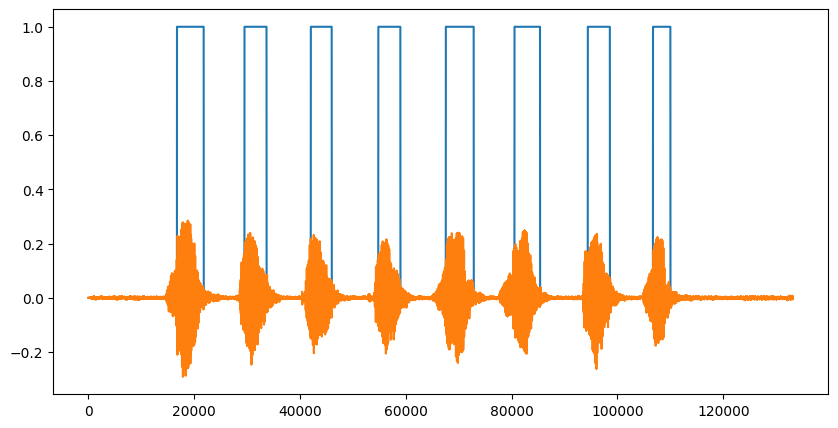

In [5]:
# Результат работы VAD
vad_vis(index=5, x_train=X_train, vad_trained=train_VA)

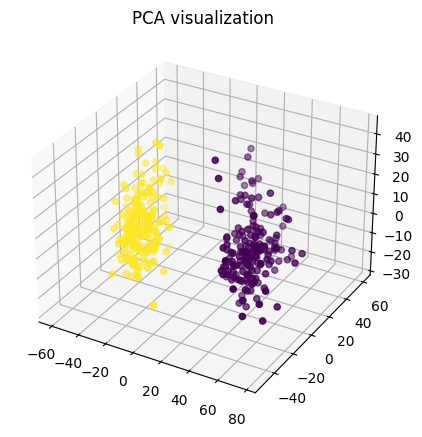

In [6]:
x_embedded = PCA(n_components=3).fit_transform(x_train)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter3D(x_embedded[:, 0], x_embedded[:, 1], x_embedded[:, 2], c=y_train)
ax.set_title('PCA visualization');

*`Как видно из визуализации с помощью PCA - выборка линейна разделима`*

### Классификация с использованием квадратичного дискриминантного анализа

`Линейный дискриминантный анализ (ЛДА) — это метод машинного обучения, применяемый для нахождения линейных комбинаций признаков, наилучшим образом разделяющих два или более класса объектов или событий. Полученная комбинация может быть использована в качестве линейного классификатора или для сокращения размерности пространства признаков перед последующей классификацией.`

In [7]:
clf = QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0, store_covariance=False, tol=0.0001)
clf.fit(x_train, y_train);

### Оценка классификации на тестовом подмножестве

In [8]:
print(sklearn.metrics.classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        49

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



### Визуализация кривых обучения

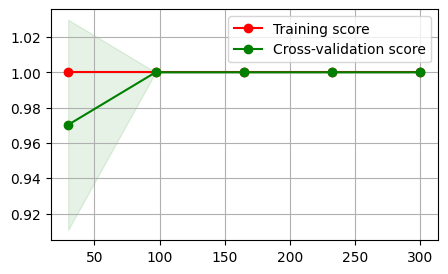

In [9]:
learning_curve_vis(clf, x_train, y_train, 'roc_auc')

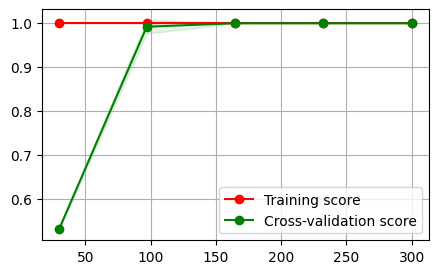

In [10]:
learning_curve_vis(clf, x_train, y_train, 'accuracy')